In [92]:
import os
import json
import pandas as pd
import numpy as np
import functools
from dotenv import load_dotenv
from mistralai.client import MistralClient
from mistralai.models.chat_completion import ChatMessage
from utils import load_mistral_api_key

# Load API key
api_key, dlai_endpoint = load_mistral_api_key(ret_key=True)

# Load Excel Data
excel_file = r"F:\Project_Mistral\Mutual Funds.xlsx"
df = pd.read_excel(excel_file)

# Function to convert percentage values to float and keep '%'
def convert_percent(value):
    if isinstance(value, str):
        if '-' in value:
            return np.nan  # replace with NaN for missing data
        else:
            return float(value.replace('%', '').strip())  # remove '%' and convert to float
    elif isinstance(value, (int, float)):
        return value  # if value is already a number, return it as is
    else:
        return np.nan  # if value is neither string nor number, replace with NaN

# Function to convert fund size to int64 and keep 'Cr'
def convert_fund_size(value):
    if isinstance(value, str):
        value = value.replace('₹', '').replace(' Cr', '').strip()
        if value == '-':
            return np.nan  # replace with NaN for missing data
        else:
            return float(value)  # remove '₹' and 'Cr', convert to float
    elif isinstance(value, (int, float)):
        return value  # if value is already a number, return it as is
    else:
        return np.nan  # if value is neither string nor number, replace with NaN

# Function to convert NAV to float
def convert_nav(value):
    if isinstance(value, str):
        value = value.replace('₹', '').strip()
        if value == '-':
            return np.nan  # replace with NaN for missing data
        else:
            return float(value)  # remove '₹' and convert to float
    elif isinstance(value, (int, float)):
        return value  # if value is already a number, return it as is
    else:
        return np.nan  # if value is neither string nor number, replace with NaN

# Function to convert expense ratio to float
def convert_expense_ratio(value):
    if isinstance(value, str):
        if '-' in value:
            return np.nan  # replace with NaN for missing data
        else:
            return float(value.replace('%', '').strip())  # remove '%' and convert to float
    elif isinstance(value, (int, float)):
        return value  # if value is already a number, return it as is
    else:
        return np.nan  # if value is neither string nor number, replace with NaN

# Apply these functions to the columns
df['1Y'] = df['1Y'].apply(convert_percent)
df['2Y'] = df['2Y'].apply(convert_percent)
df['3Y'] = df['3Y'].apply(convert_percent)
df['5Y'] = df['5Y'].apply(convert_percent)

df['Fund Size'] = df['Fund Size'].apply(convert_fund_size)

df['NAV'] = df['NAV'].apply(convert_nav)

df['Expense Ratio'] = df['Expense Ratio'].apply(convert_expense_ratio)

# Function to Retrieve Category by Scheme Name
def retrieve_category(df: pd.DataFrame, scheme_name: str) -> str:
    if scheme_name in df["Scheme Name"].values:
        return json.dumps(
            {"Category": df[df["Scheme Name"] == scheme_name]["Category"].item()}
        )
    return json.dumps({"error": "Scheme Name not found."})

"""

# Function to Find Scheme with Highest Return for a Given Period
def find_highest_return(df: pd.DataFrame, period: str) -> str:
    if period not in ["1Y", "2Y", "3Y", "5Y"]:
        return json.dumps({"error": "Invalid period. Choose from 1Y, 2Y, 3Y, 5Y."})
    
    df[period] = pd.to_numeric(df[period], errors="coerce")  # Convert to numeric
    highest = df.loc[df[period].idxmax()]  # Find row with highest return
    
    return json.dumps({
        "Scheme Name": highest["Scheme Name"],
        "Return": highest[period]
    })

"""

def find_highest_return(df: pd.DataFrame, period: str, scheme_list: list = None) -> str:
    if period not in ["1Y", "2Y", "3Y", "5Y"]:
        return json.dumps({"error": "Invalid period. Choose from 1Y, 2Y, 3Y, 5Y."})
    
    # Create a copy of the dataframe to work with
    working_df = df.copy()
    
    # If scheme_list is provided, filter the dataframe
    if scheme_list:
        working_df = working_df[working_df["Scheme Name"].isin(scheme_list)]
    
    # Convert to numeric using the working copy
    working_df.loc[:, period] = pd.to_numeric(working_df[period], errors="coerce")
    
    # Find row with highest return
    highest = working_df.loc[working_df[period].idxmax()]
    
    return json.dumps({
        "Scheme Name": highest["Scheme Name"],
        "Return": highest[period]
    })



# Function to Find Schemes by Keyword (e.g., Defence)
def find_schemes_by_keyword(df: pd.DataFrame, keyword: str) -> str:
    filtered_df = df[df["Scheme Name"].str.contains(keyword, case=False, na=False)]
    
    if filtered_df.empty:
        return json.dumps({"error": "No schemes found with the given keyword."})
    
    return json.dumps({"Schemes": filtered_df["Scheme Name"].tolist()})


# Function to Retrieve NAV by Scheme Name
def retrieve_nav(df: pd.DataFrame, scheme_name: str) -> str:
    if scheme_name in df["Scheme Name"].values:
        return json.dumps(
            {"NAV": df[df["Scheme Name"] == scheme_name]["NAV"].item()}
        )
    return json.dumps({"error": "Scheme Name not found."})

# Function to Retrieve CRISIL Rating
def retrieve_crisil_rating(df: pd.DataFrame, scheme_name: str) -> str:
    if scheme_name in df["Scheme Name"].values:
        return json.dumps(
            {"CRISIL_Rating": df[df["Scheme Name"] == scheme_name]["CRISIL_Rating"].item()}
        )
    return json.dumps({"error": "Scheme Name not found."})

# Function to Retrieve CRISIL Performance
def retrieve_crisil_performance(df: pd.DataFrame, scheme_name: str) -> str:
    if scheme_name in df["Scheme Name"].values:
        return json.dumps(
            {"CRISIL_Performance": df[df["Scheme Name"] == scheme_name]["CRISIL_Performance"].item()}
        )
    return json.dumps({"error": "Scheme Name not found."})

# Function to Retrieve Expense Ratio
def retrieve_expense_ratio(df: pd.DataFrame, scheme_name: str) -> str:
    if scheme_name in df["Scheme Name"].values:
        return json.dumps(
            {"Expense_Ratio": df[df["Scheme Name"] == scheme_name]["Expense Ratio"].item()}
        )
    return json.dumps({"error": "Scheme Name not found."})

# Function to Retrieve Returns (1Y, 2Y, 3Y, 5Y)
def retrieve_return(df: pd.DataFrame, scheme_name: str, period: str) -> str:
    if period not in ["1Y", "2Y", "3Y", "5Y"]:
        return json.dumps({"error": "Invalid period. Choose from '1Y', '2Y', '3Y', '5Y'."})

    if scheme_name in df["Scheme Name"].values:
        return json.dumps(
            {f"{period}_Return": df[df["Scheme Name"] == scheme_name][period].item()}
        )
    return json.dumps({"error": "Scheme Name not found."})

import matplotlib.pyplot as plt
import json

# Function to Create a Bar Chart for Returns
def create_return_chart(schemes: list, returns: list, period: str) -> str:
    if not schemes or not returns:
        return json.dumps({"error": "No data available for chart."})

    plt.figure(figsize=(12, 6))
    plt.barh(schemes, returns, color='skyblue')
    plt.xlabel(f"{period} Return (%)")
    plt.ylabel("Scheme Name")
    plt.title(f"Comparison of {period} Returns for Mutual Fund Schemes")
    plt.gca().invert_yaxis()  # Invert y-axis to show highest return on top
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    
    # Display the chart
    plt.show()
    
    return json.dumps({"message": "Chart displayed successfully."})


"""
# Function to Retrieve NAV by Scheme Name
def retrieve_nav(df: pd.DataFrame, scheme_name: str) -> str:
    if scheme_name in df["Scheme Name"].values:
        nav_value = df[df["Scheme Name"] == scheme_name]["NAV"].item()
        return json.dumps(
            {
                "scheme_name": scheme_name,  # Include the scheme name
                "NAV": nav_value
            }
        )
    return json.dumps({"error": "Scheme Name not found."})
"""
    
# Define Tool for NAV Retrieval
tool_MF_NAV = {
    "type": "function",
    "function": {
        "name": "retrieve_nav",
        "description": "Get latest NAV of a mutual fund",
        "parameters": {
            "type": "object",
            "properties": {
                "scheme_name": {"type": "string", "description": "Mutual fund scheme name"},
            },
            "required": ["scheme_name"],
        },
    },
}

# Define Tool for CRISIL Rating Retrieval
tool_MF_CRISIL_Rating = {
    "type": "function",
    "function": {
        "name": "retrieve_crisil_rating",
        "description": "Get CRISIL rating of a mutual fund",
        "parameters": {
            "type": "object",
            "properties": {
                "scheme_name": {"type": "string", "description": "Mutual fund scheme name"},
            },
            "required": ["scheme_name"],
        },
    },
}

# Define Tool for CRISIL Performance Retrieval
tool_MF_CRISIL_Performance = {
    "type": "function",
    "function": {
        "name": "retrieve_crisil_performance",
        "description": "Get CRISIL performance of a mutual fund",
        "parameters": {
            "type": "object",
            "properties": {
                "scheme_name": {"type": "string", "description": "Mutual fund scheme name"},
            },
            "required": ["scheme_name"],
        },
    },
}

# Define Tool for Expense Ratio Retrieval
tool_MF_Expense_Ratio = {
    "type": "function",
    "function": {
        "name": "retrieve_expense_ratio",
        "description": "Get expense ratio of a mutual fund",
        "parameters": {
            "type": "object",
            "properties": {
                "scheme_name": {"type": "string", "description": "Mutual fund scheme name"},
            },
            "required": ["scheme_name"],
        },
    },
}

# Define Tool for Returns (1Y, 2Y, 3Y, 5Y) Retrieval
tool_MF_Return = {
    "type": "function",
    "function": {
        "name": "retrieve_return",
        "description": "Get return of a mutual fund for a given period (1Y, 2Y, 3Y, 5Y)",
        "parameters": {
            "type": "object",
            "properties": {
                "scheme_name": {"type": "string", "description": "Mutual fund scheme name"},
                "period": {"type": "string", "description": "Return period (1Y, 2Y, 3Y, 5Y)"},
            },
            "required": ["scheme_name", "period"],
        },
    },
}

# Define Available Tools
tool_MF_Category = {
    "type": "function",
    "function": {
        "name": "retrieve_category",
        "description": "Get category of a mutual fund",
        "parameters": {
            "type": "object",
            "properties": {
                "scheme_name": {"type": "string", "description": "Mutual fund scheme name"},
            },
            "required": ["scheme_name"],
        },
    },
}


"""
tool_Highest_Return = {
    "type": "function",
    "function": {
        "name": "find_highest_return",
        "description": "Find the scheme with the highest return for a given period",
        "parameters": {
            "type": "object",
            "properties": {
                "period": {"type": "string", "description": "Period: 1Y, 2Y, 3Y, or 5Y"},
            },
            "required": ["period"],
        },
    },
}
"""

tool_Highest_Return = {
    "type": "function",
    "function": {
        "name": "find_highest_return",
        "description": "Find the scheme with the highest return for a given period",
        "parameters": {
            "type": "object",
            "properties": {
                "period": {
                    "type": "string", 
                    "description": "Period: 1Y, 2Y, 3Y, or 5Y"
                },
                "scheme_list": {
                    "type": "array",
                    "items": {
                        "type": "string"
                    },
                    "description": "Optional list of scheme names to filter by"
                }
            },
            "required": ["period"]
        }
    }
}


tool_Keyword_Search = {
    "type": "function",
    "function": {
        "name": "find_schemes_by_keyword",
        "description": "Find mutual fund schemes based on a keyword in their name",
        "parameters": {
            "type": "object",
            "properties": {
                "keyword": {"type": "string", "description": "Keyword to search for schemes"},
            },
            "required": ["keyword"],
        },
    },
}

tool_MF_Return_Chart = {
    "type": "function",
    "function": {
        "name": "create_return_chart",
        "description": "Generate a bar chart for mutual fund scheme returns",
        "parameters": {
            "type": "object",
            "properties": {
                "schemes": {
                    "type": "array",
                    "items": {"type": "string"},
                    "description": "List of mutual fund scheme names"
                },
                "returns": {
                    "type": "array",
                    "items": {"type": "number"},
                    "description": "List of corresponding mutual fund returns"
                },
                "period": {
                    "type": "string",
                    "description": "Return period (1Y, 2Y, 3Y, 5Y)"
                }
            },
            "required": ["schemes", "returns", "period"],
        },
    },
}


tools = [tool_MF_Category, tool_Highest_Return, tool_Keyword_Search, tool_MF_NAV, tool_MF_CRISIL_Rating, tool_MF_CRISIL_Performance, tool_MF_Expense_Ratio, tool_MF_Return, tool_MF_Return_Chart]

# Function Mapping
names_to_functions = {
    "retrieve_category": functools.partial(retrieve_category, df=df),
    "find_highest_return": functools.partial(find_highest_return, df=df),
    "find_schemes_by_keyword": functools.partial(find_schemes_by_keyword, df=df),
    "retrieve_nav": functools.partial(retrieve_nav, df=df),
    "retrieve_crisil_rating": functools.partial(retrieve_crisil_rating, df=df),
    "retrieve_crisil_performance": functools.partial(retrieve_crisil_performance, df=df),
    "retrieve_expense_ratio": functools.partial(retrieve_expense_ratio, df=df),
    "retrieve_return": functools.partial(retrieve_return, df=df),
    "create_return_chart": functools.partial(create_return_chart),
}

In [93]:
# Initialize Chat
client = MistralClient(api_key=api_key)
model = "mistral-large-latest"

# User Query Example
chat_history = [
    ChatMessage(role="user", content="Can you get me schemes that invest in gold etf with NAV between 10 to 50?")
]
response = client.chat(model=model, messages=chat_history, tools=tools, tool_choice="any")
# Append assistant message with tool call
assistant_message = response.choices[0].message
chat_history.append(assistant_message)  # Ensure assistant acknowledges tool usage
# Extract Tool Call
tool_call = response.choices[0].message.tool_calls[0]
function_name = tool_call.function.name
function_params = json.loads(tool_call.function.arguments)
function_result = names_to_functions[function_name](**function_params)

# Append Result to Chat
chat_history.append({
    "role": "tool",
    "name": function_name,
    "content": function_result,
    "tool_call_id": tool_call.id
})
# Get Final Response
final_response = client.chat(model=model, messages=chat_history)
print(final_response.choices[0].message.content)


I have found the following schemes that invest in Gold ETFs. However, I do not have real-time data on their NAVs. Please check their latest NAVs to see if they fall within your desired range of 10 to 50:

1. Baroda BNP Paribas Gold ETF
2. Edelweiss Gold ETF
3. Groww Gold ETF FOF - Direct Plan - Growth
4. Groww Gold ETF FOF - Regular Plan - Growth
5. Groww Gold ETF
6. Invesco India Gold ETF Fund of Fund - Direct Plan - Growth
7. Invesco India Gold ETF Fund of Fund - Growth
8. LIC MF Gold ETF Fund of Fund - Direct Plan - Growth
9. LIC MF Gold ETF Fund of Fund - Growth
10. Zerodha Gold ETF FOF - Direct Plan - Growth
11. Zerodha Gold ETF
12. DSP Gold ETF Fund of Fund - Direct Plan - Growth
13. DSP Gold ETF Fund of Fund - Regular Plan - Growth
14. DSP Gold ETF
15. Mirae Asset Gold ETF Fund of Fund - Regular Plan - Growth
16. Mirae Asset Gold ETF Fund of Fund - Direct Plan - Growth
17. Mirae Asset Gold ETF
18. Tata Gold ETF Fund of Fund - Direct Plan - Growth
19. Tata Gold ETF Fund of Fund -

In [94]:
# Append the last response from the assistant to the chat history
assistant_reply = ChatMessage(role="assistant", content=final_response.choices[0].message.content)
chat_history.append(assistant_reply)
# User continues the conversation
chat_history.append(ChatMessage(role="user", content="please proceed"))
# Call the model again
new_response = client.chat(model=model, messages=chat_history, tools=tools, tool_choice="any")
assistant_message = new_response.choices[0].message
chat_history.append(assistant_message)
# Extract Tool Calls
for tool_call in new_response.choices[0].message.tool_calls:
    function_name = tool_call.function.name
    function_params = json.loads(tool_call.function.arguments)
    function_result = names_to_functions[function_name](**function_params)

    # Append Result to Chat
    chat_history.append({
        "role": "tool",
        "name": function_name,
        "content": function_result,
        "tool_call_id": tool_call.id
    })
# Get Final Response
final1_response = client.chat(model=model, messages=chat_history)
print(final1_response.choices[0].message.content)

The following schemes have NAVs between 10 and 50:

1. **Groww Gold ETF FOF - Direct Plan - Growth** - NAV: 10.2748
2. **Groww Gold ETF FOF - Regular Plan - Growth** - NAV: 10.2675
3. **Invesco India Gold ETF Fund of Fund - Direct Plan - Growth** - NAV: 24.1376
4. **Invesco India Gold ETF Fund of Fund - Growth** - NAV: 23.2925
5. **LIC MF Gold ETF Fund of Fund - Direct Plan - Growth** - NAV: 22.4673
6. **LIC MF Gold ETF Fund of Fund - Growth** - NAV: 21.3567
7. **Zerodha Gold ETF FOF - Direct Plan - Growth** - NAV: 10.7333
8. **Zerodha Gold ETF** - NAV: 12.7855
9. **DSP Gold ETF Fund of Fund - Direct Plan - Growth** - NAV: 12.9431
10. **DSP Gold ETF Fund of Fund - Regular Plan - Growth** - NAV: 12.8844
11. **Mirae Asset Gold ETF Fund of Fund - Regular Plan - Growth** - NAV: 10.322
12. **Mirae Asset Gold ETF Fund of Fund - Direct Plan - Growth** - NAV: 10.33
13. **Tata Gold ETF Fund of Fund - Direct Plan - Growth** - NAV: 12.7404
14. **Tata Gold ETF Fund of Fund - Regular Plan - Growth*

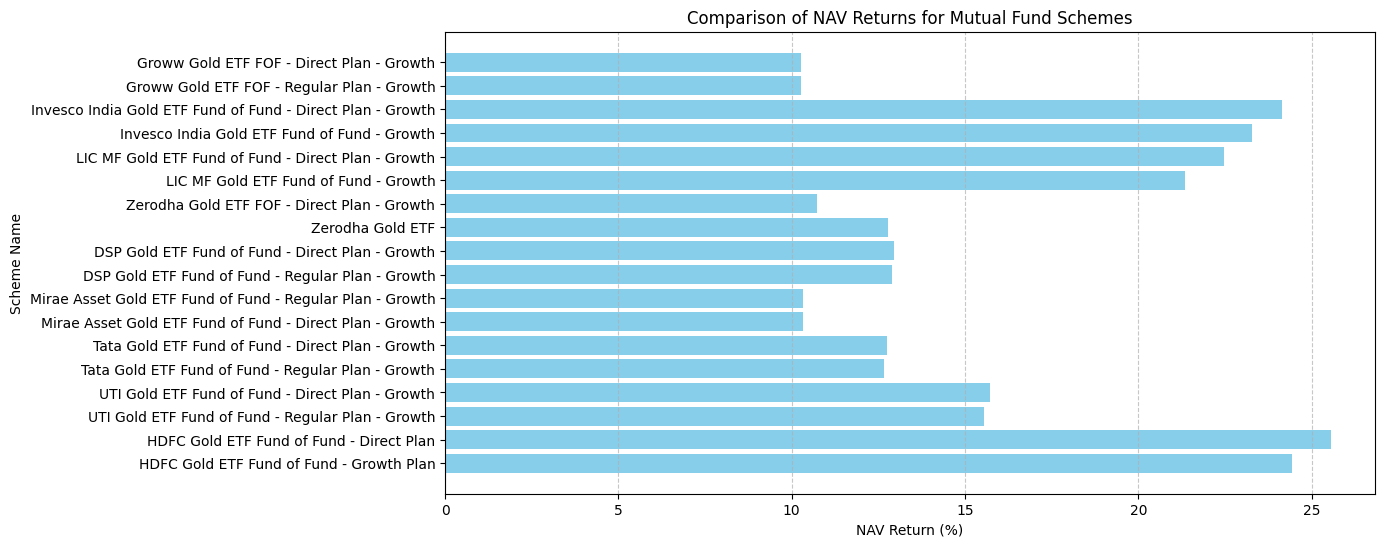

Chart has been plotted successfully


In [95]:
# Append the last response from the assistant to the chat history
assistant_reply = ChatMessage(role="assistant", content=final1_response.choices[0].message.content)
chat_history.append(assistant_reply)
# User continues the conversation
chat_history.append(ChatMessage(role="user", content="Please plot a chart between these schemes and their NAV"))
# Call the model again
new_response1 = client.chat(model=model, messages=chat_history, tools=tools, tool_choice="any")
assistant_message = new_response1.choices[0].message
chat_history.append(assistant_message)
# Extract Tool Calls
for tool_call in new_response1.choices[0].message.tool_calls:
    function_name = tool_call.function.name
    function_params = json.loads(tool_call.function.arguments)
    function_result = names_to_functions[function_name](**function_params)

    # Append Result to Chat
    chat_history.append({
        "role": "tool",
        "name": function_name,
        "content": function_result,
        "tool_call_id": tool_call.id
    })
# Get Final Response
final2_response = client.chat(model=model, messages=chat_history)
print(final2_response.choices[0].message.content)

In [96]:
# Append the last response from the assistant to the chat history
assistant_reply = ChatMessage(role="assistant", content=final2_response.choices[0].message.content)
chat_history.append(assistant_reply)
# User continues the conversation
chat_history.append(ChatMessage(role="user", content="which one of these are from zerodha?"))
# Call the model again
new_response2 = client.chat(model=model, messages=chat_history, tools=tools, tool_choice="any")
assistant_message = new_response2.choices[0].message
chat_history.append(assistant_message)
# Extract Tool Calls
for tool_call in new_response2.choices[0].message.tool_calls:
    function_name = tool_call.function.name
    function_params = json.loads(tool_call.function.arguments)
    function_result = names_to_functions[function_name](**function_params)

    # Append Result to Chat
    chat_history.append({
        "role": "tool",
        "name": function_name,
        "content": function_result,
        "tool_call_id": tool_call.id
    })
# Get Final Response
final3_response = client.chat(model=model, messages=chat_history)
print(final3_response.choices[0].message.content)

The following schemes are from Zerodha:

1. Zerodha Gold ETF FOF - Direct Plan - Growth
2. Zerodha Gold ETF
